# Input Value

In [1]:
url = 'https://youtu.be/wbM4HS1sbXM'
text = 'a baby with her mother'
model_name = 'clip'
kfe = False

# Video Load

In [2]:
import matplotlib.pyplot as plt
import cv2, pafy
import re

def extract_video_id(youtube_link):
    index = youtube_link.find('?')

    if index != -1 :
        youtube_link = youtube_link[:index]

    return youtube_link

def video_load_from_url(url) :
    url = extract_video_id(url)
    video = pafy.new(url)

    best = video.getbest(preftype = 'mp4')

    cap = cv2.VideoCapture(best.url)
    
    return cap, url

In [7]:
# video load
print('video load ... ')
cap, url = video_load_from_url(url)
print('video load complete ')

video load ... 
video load complete 


# Key Frame Extraction

In [3]:
import os
import cv2
import csv
import numpy as np
import time
import peakutils
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from scenedetect import detect, ContentDetector


def scale(img, xScale, yScale):
    res = cv2.resize(img, None, fx=xScale, fy=yScale, interpolation=cv2.INTER_AREA)
    return res


def convert_frame_to_grayscale(frame):
    grayframe = None
    gray = None
    if frame is not None:
        cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = scale(gray, 1, 1)
        grayframe = scale(gray, 1, 1)
        gray = cv2.GaussianBlur(gray, (9, 9), 0.0)
    return grayframe, gray


def key_frame_detection(cap, kfe=False, Thres=0.3, plotMetrics=False, verbose=False):

    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    spf = 1 / fps

    if kfe == False :
        frame_list = []
        time_spans = []
        for i in tqdm(range(0, length)) :
            ret, frame = cap.read()

            if i % 12 == 0 :
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame_list.append(frame)
                time_spans.append(spf * i)

        return frame_list, time_spans
  
    if (cap.isOpened()== False):
        print("Error opening video file")

    lstfrm = []
    lstdiffMag = []
    timeSpans = []
    images = []
    full_color = []
    lastFrame = None
    
    # Read until video is completed
    for i in tqdm(range(length)):
        ret, frame = cap.read()
        grayframe, blur_gray = convert_frame_to_grayscale(frame)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        frame_number = cap.get(cv2.CAP_PROP_POS_FRAMES) - 1
        lstfrm.append(frame_number)
        images.append(grayframe)
        full_color.append(frame)
        if frame_number == 0:
            lastFrame = blur_gray

        diff = cv2.subtract(blur_gray, lastFrame)
        diffMag = cv2.countNonZero(diff)
        lstdiffMag.append(diffMag)
        time_Span = i * spf
        timeSpans.append(time_Span)
        lastFrame = blur_gray

    cap.release()
    y = np.array(lstdiffMag)
    base = peakutils.baseline(y, 2)
    indices = peakutils.indexes(y-base, Thres, min_dist=1)

    return_keyframe = []
    return_frame_times = []

    for x in indices:https://youtu.be/wbM4HS1sbXM?t=1

    return return_keyframe, return_frame_times


# main method 2 - SCD

def scene_change_detector(video_path):
    scene_list = detect(video_path, ContentDetector())
    return scene_list

/home/vision/anaconda3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# KFE
print('key frame extraction ... ')
frame_list, time_line = key_frame_detection(cap, kfe)
print('key frame extraction complete ')

key frame extraction ... 


100%|██████████| 1085/1085 [01:39<00:00, 10.86it/s]

key frame extraction complete 


# Data Loader

In [9]:
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import torch
from PIL import Image


class custom_dataset(torch.utils.data.Dataset): 
    def __init__(self, frame_list, model):
        self.frame_list = frame_list
        self.model = model
        self.pil_image_list = [self.frame_to_PIL(frame) for frame in frame_list]
        
        self.image_size = 224

        self.mean = (0.48145466, 0.4578275, 0.40821073)
        self.std = (0.26862954, 0.26130258, 0.27577711)
      
        self.transform = transforms.Compose(
                [
                    transforms.Resize(
                        (self.image_size, self.image_size), interpolation=InterpolationMode.BICUBIC
                    ),
                    transforms.ToTensor(),
                    transforms.Normalize(self.mean, self.std),
                ]
            )

    def __len__(self):
        return len(self.pil_image_list)

    def __getitem__(self, idx):
        return self.transform(self.pil_image_list[idx])

    def frame_to_PIL(self, frame):
        pil_image = Image.fromarray(frame)
        return pil_image

In [10]:
from torch.utils.data import DataLoader

# dataloader
dataset = custom_dataset(frame_list, model_name)
dataloader = DataLoader(dataset, batch_size=32)

# Model Load

In [11]:
from lavis.models import load_model_and_preprocess
import clip

def load_blip(device) :
    model, _, _ = load_model_and_preprocess(
        name="blip2", model_type="pretrain", is_eval=True, device=device
    )

    return model.float()

def load_clip(device) :
    model, _ = clip.load("ViT-B/32", device=device)

    return model

def load_model(name, device) :
    if name == "clip" :
        return load_clip(device)
    
    elif name == "blip" :
        return load_blip(device)

In [12]:
# load model
print('model load ...')
device = "cuda" if torch.cuda.is_available() else "cpu"
model = load_model(model_name, device)
print('model load complete')

model load ...
model load complete


# Infrence

In [6]:
import clip
from tqdm import tqdm
from text_search.textSimilarity import text_similarity

def inference(model_name, text, model, dataloader, device) :
    if model_name == "clip" :
        logits = []
        text = clip.tokenize(['a baby with her mother']).to(device)
        for data in tqdm(dataloader) :
            data = data.to(device)
            image_features = model.encode_image(data)
            text_features = model.encode_text(text)
            
            logits_per_image, logits_per_text = model(data, text)
            logits.append(logits_per_image)

            flat = [item.item() for logit in logits for item in logit]
            max_index = flat.index(max(flat))


    elif model_name == "blip" :
        msg_list = []
        for data in tqdm(dataloader) :
            data = data.to(device)
            msg = model.generate({"image": data})
            msg_list.append(msg)
        
        flat_msg_list = [msg for sublist in msg_list for msg in sublist]
        max_index = text_similarity(flat_msg_list, 'a baby with her mother')


    return max_index

In [13]:
# inference
print('inference loading ... ')
model.eval()
max_index = inference(model_name, text, model, dataloader, device)
print('infrence complete ')

inference loading ... 


100%|██████████| 3/3 [00:01<00:00,  1.84it/s]

infrence complete 


# Result

https://youtu.be/wbM4HS1sbXM?t=2


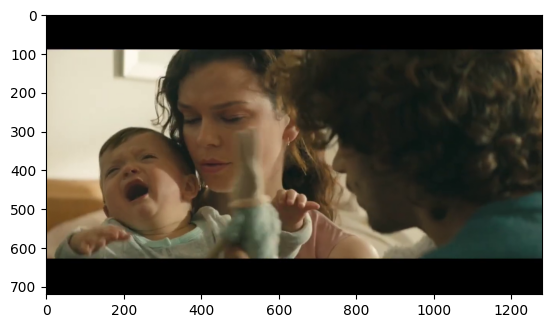

In [14]:
print(url + '?t=' + str(int(time_line[max_index])))
plt.imshow(frame_list[max_index])